In [1]:
import os
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain
from tqdm import tqdm
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from skimage import morphology, filters, measure
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt


#### Code

In [8]:
DIR_PELVIS = os.path.join(os.getcwd(), "..", "data", "Task1", "pelvis")
HU_THRESHOLD = 2000
list_pelvis_image_dir = [os.path.join(DIR_PELVIS, f) for f in os.listdir(DIR_PELVIS) if f.startswith("1P")]

DIR_LABELS = os.path.join(os.getcwd(), "..", "labels")
FILE_MISSING = os.path.join(DIR_LABELS, "missing_Ömer.txt")
LABELS_RAW = os.path.join(DIR_LABELS, "labels_raw.json")

In [25]:
class MetalSliceMaxHUPlotter:

    def __init__(self, vol_data: np.ndarray, metal_slices, slice_axis: int = 2):
        if vol_data.ndim != 3:
            raise ValueError("vol_data must be a 3D array")
        self.vol_data = vol_data
        self.slice_axis = int(slice_axis)
        self.metal_slices = np.asarray(metal_slices, dtype=int)
        self._df = None

    @classmethod
    def from_nifti(cls, nifti_path: str, metal_slices, slice_axis: int = 2):
        img = nib.load(nifti_path)
        vol_data = img.get_fdata()  # applies scaling (scl_slope, scl_inter)
        return cls(vol_data, metal_slices, slice_axis)


    def build_df(self) -> pd.DataFrame:
        vol = np.moveaxis(self.vol_data, self.slice_axis, 0)  # shape -> (num_slices, H, W)
        max_hu = np.max(vol.reshape(vol.shape[0], -1), axis=1)
        slice_idx = np.arange(len(max_hu))
        label = np.isin(slice_idx, self.metal_slices).astype(int)

        self._df = pd.DataFrame({
            "slice_idx": slice_idx,
            "max_hu": max_hu,
            "label": label
        })
        return self._df

    def plot(self, tau: float = None, title=""):
        if self._df is None:
            self.build_df()
        df = self._df

        if tau is None:
            non_metal = df.loc[df["label"] == 0, "max_hu"]
            if len(non_metal) > 0:
                tau = float(non_metal.max())
            else:
                tau = 0.0
                print("tau set to 0")


        plt.figure(figsize=(10, 4))
        plt.plot(df["slice_idx"], df["max_hu"], label="Max HU")

        # Put red X markers slightly above curve max
        top_y = df["max_hu"].max() * 1.01 if len(df) else 0
        plt.scatter(
            df["slice_idx"][df["label"] == 1],
            np.full(df["label"].sum(), top_y),
            color="red", marker="x", label="Label (metal slices)"
        )

        plt.axhline(y=tau, color="g", linestyle="--", label="Threshold")
        plt.xlabel("Slice index")
        plt.ylabel("Max HU")
        plt.title(f"{title}: Slice-wise max HU vs label")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [26]:
def plot_slices_by_range(vol, slice_range, cmap="gray", title=""):
    z_slices = vol.shape[2]
    start = slice_range[0]
    end = slice_range[-1]
    slice_indices = np.linspace(start, end, 4, dtype=int)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, idx in enumerate(slice_indices):
        axes[i].imshow(vol[:, :, idx].T, cmap=cmap, origin="lower")
        axes[i].set_title(f"Slice {idx}")
        axes[i].axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Example

In [27]:
# Taken from Justin's annotations
examples = [
    ("1PA133",74,82,"Bright spots on CT, black spots on MR."),
    ("1PA136",100,121,"Articfat due two metal nail in spine."),
    ("1PA147",45,53,"Bright spots on CT, hard to tell on MR."),
    ("1PA151",46,54,"Some bright spots visible (local radiotherapy with implants) in CT difficult to spot in MR."),
    ("1PA152",56,68,"Weird bright short little lines in CT, MR shows black spots. Not as bright as other cases."),
    ("1PA169",8,82,"OOD due to hip implant.")
]

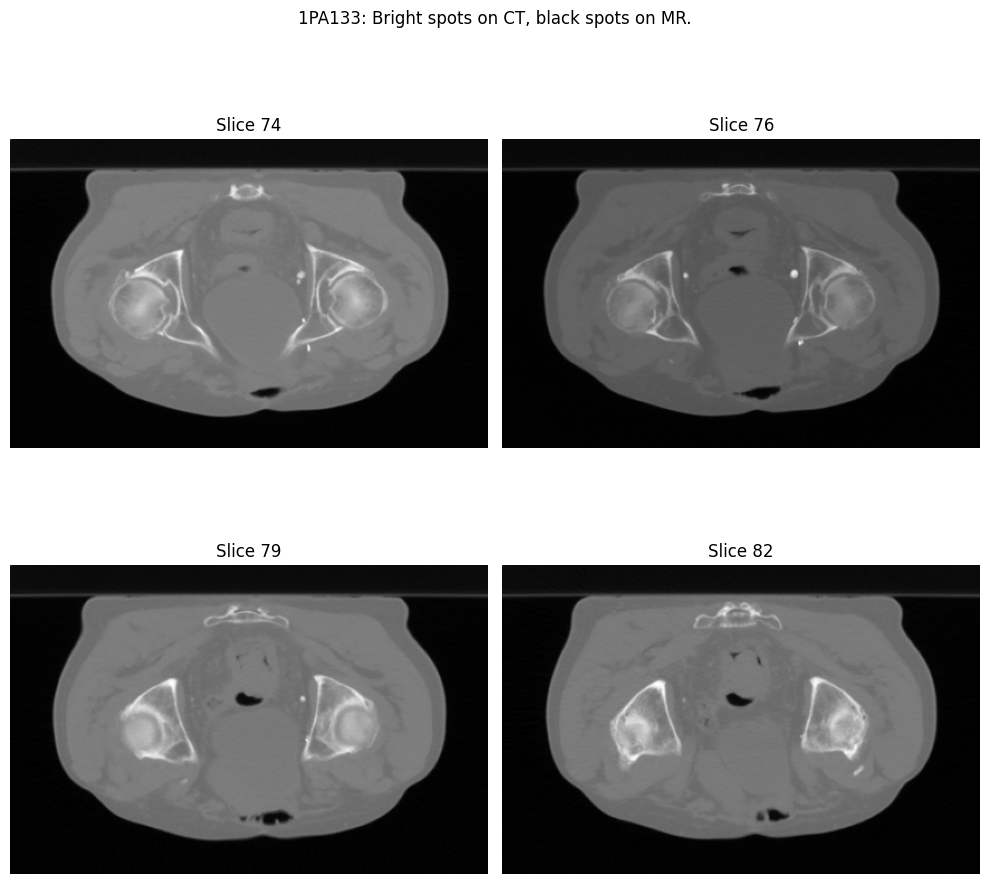

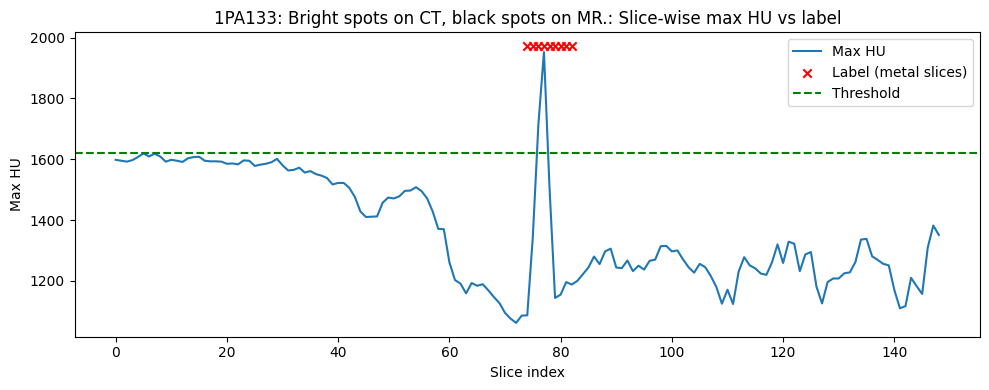

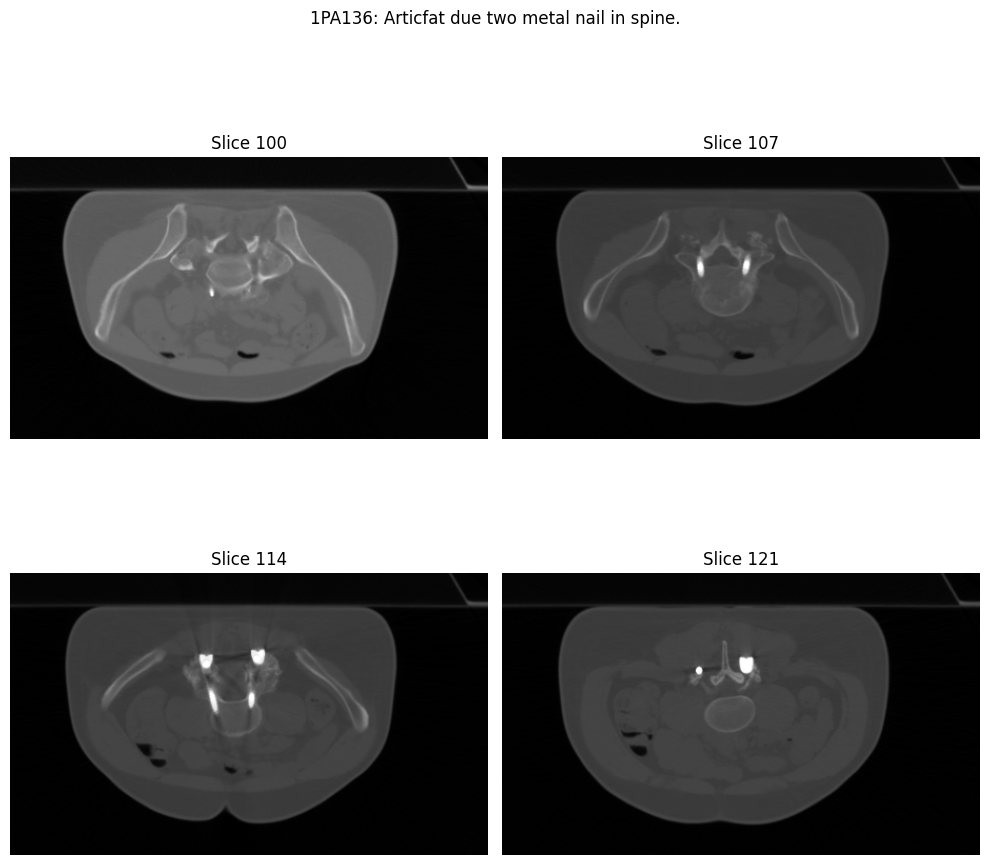

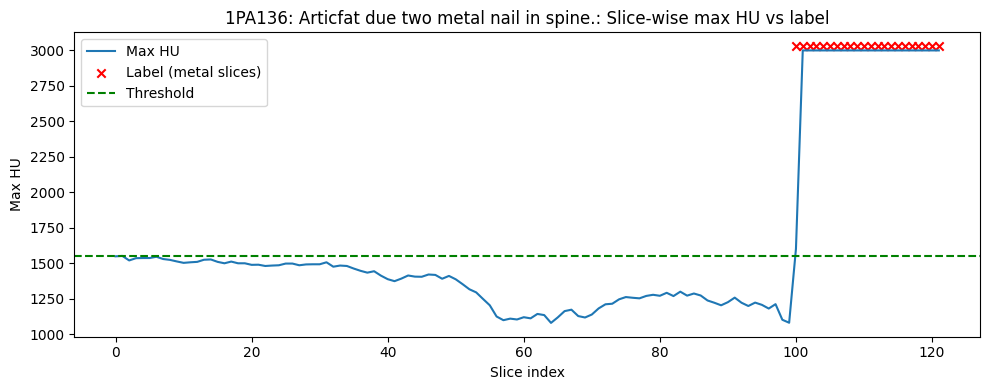

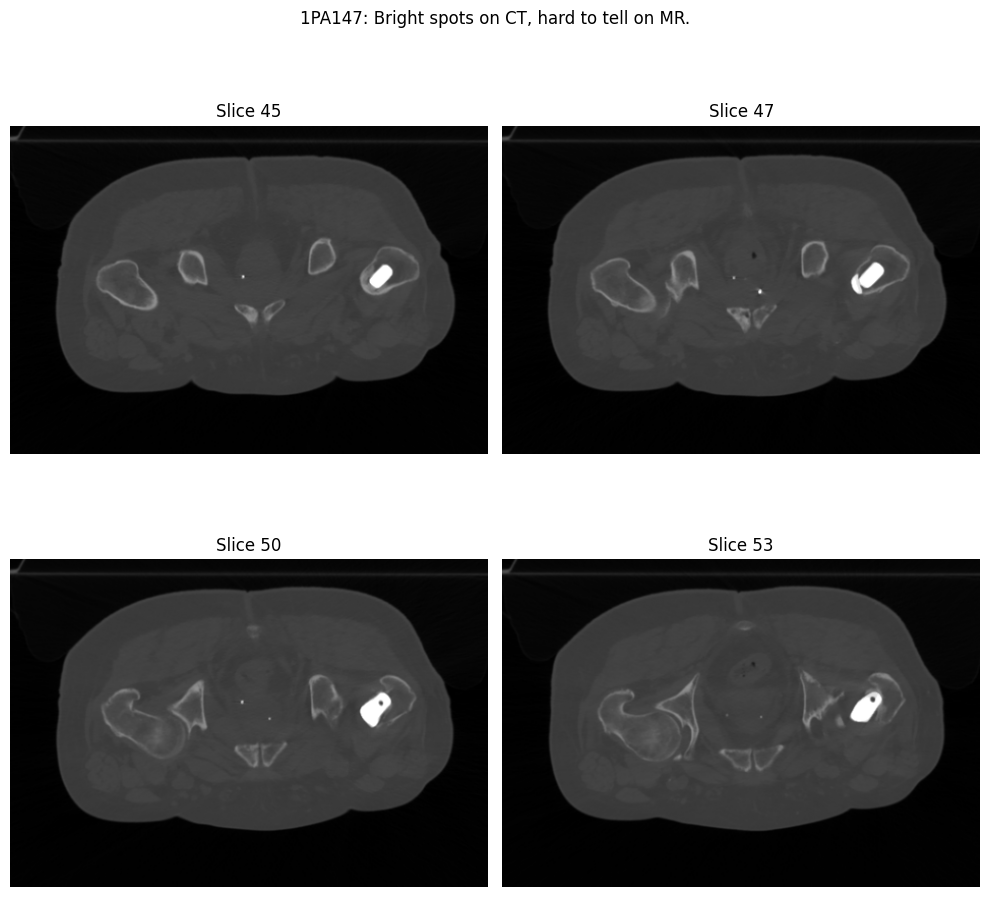

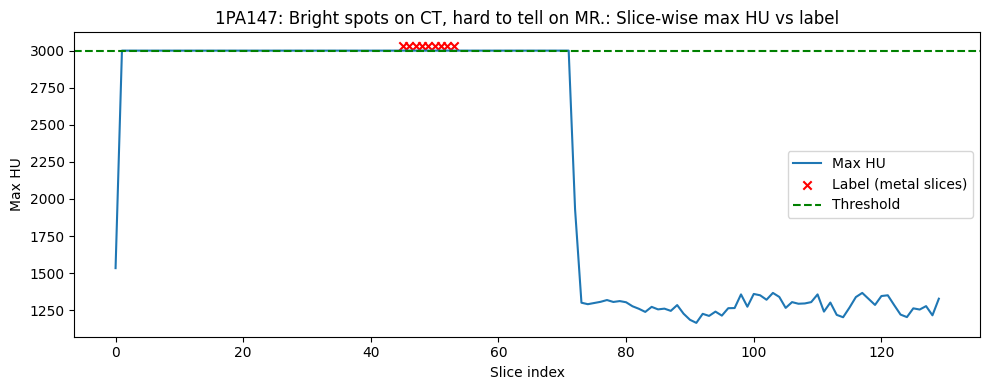

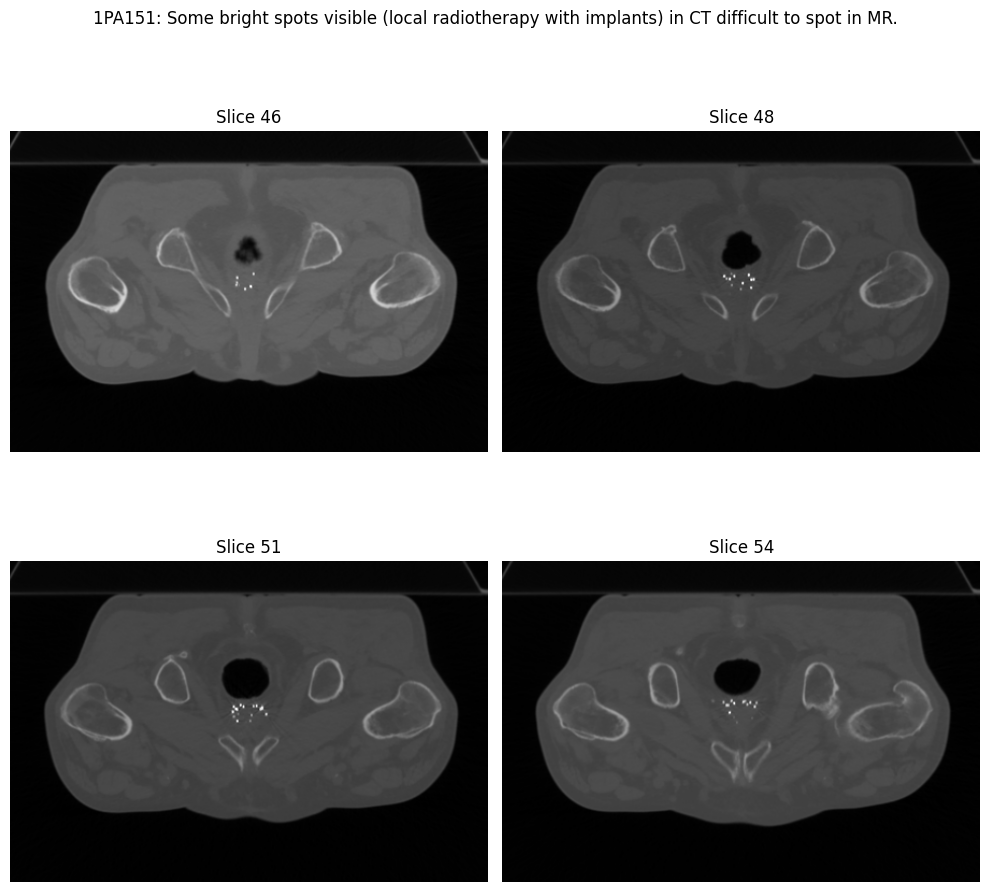

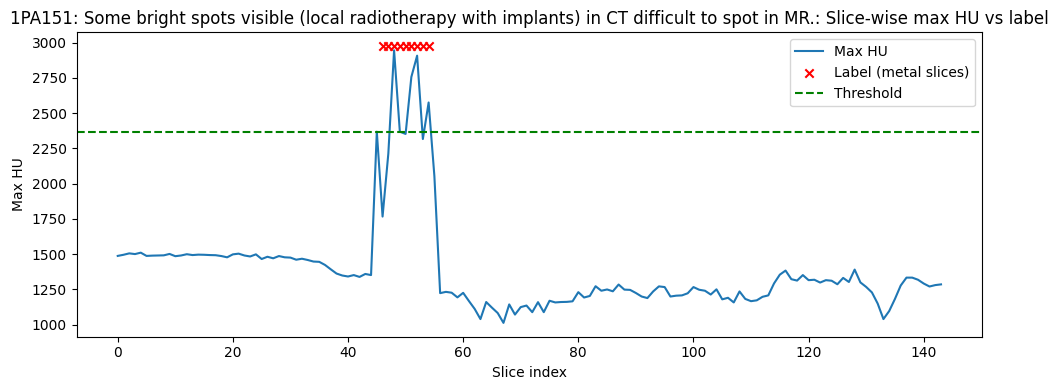

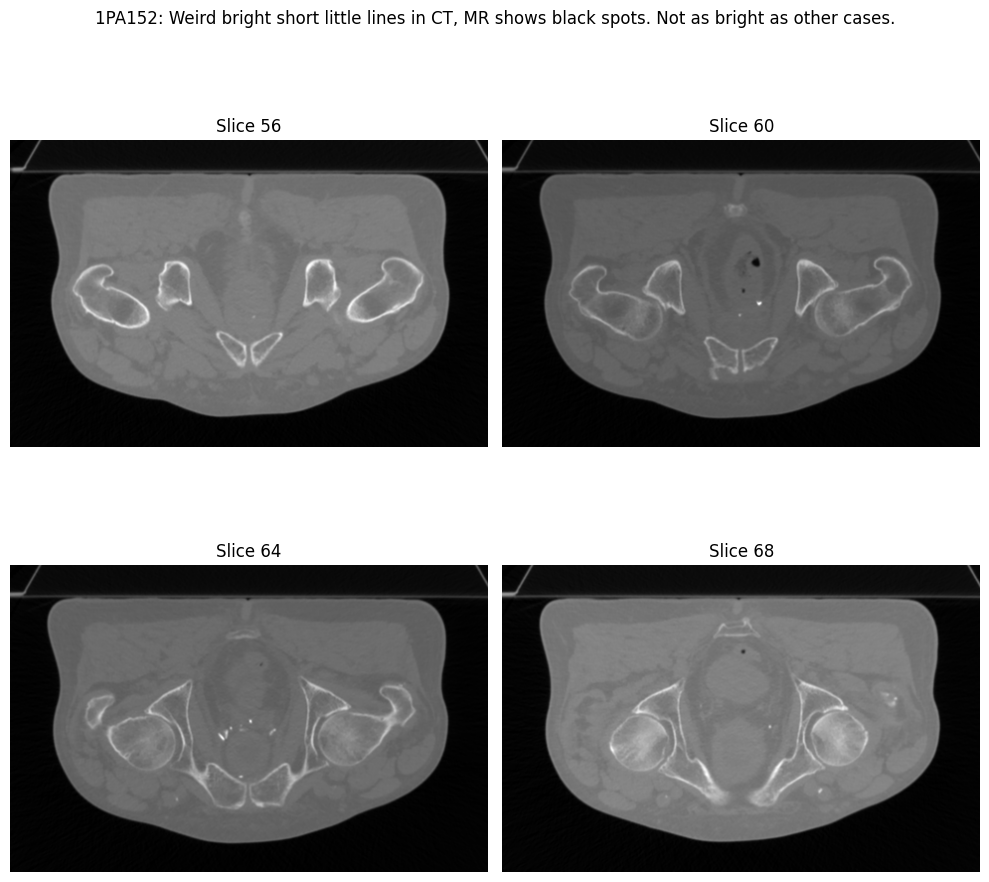

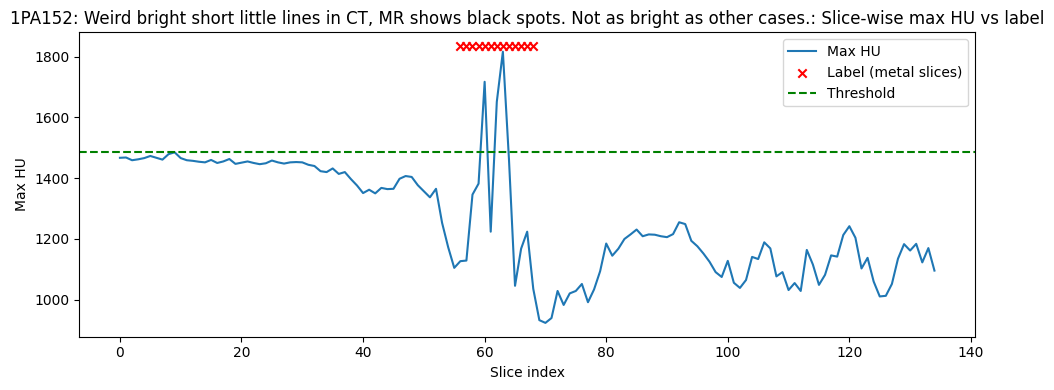

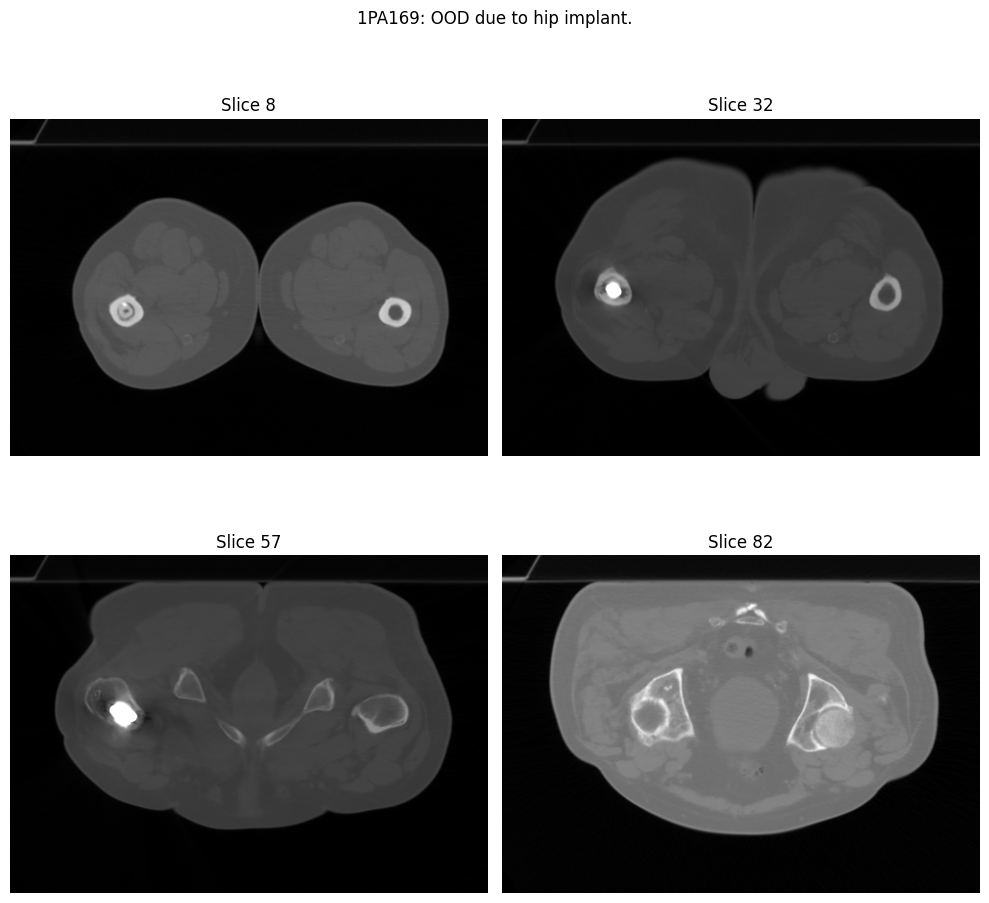

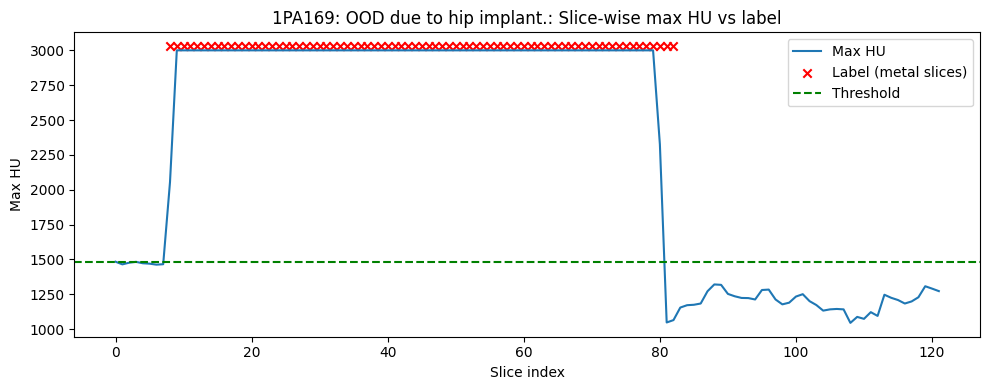

In [28]:
for example in examples:
    example_scan, note = example[0], example[3]
    path_scan = os.path.join(DIR_PELVIS, example_scan, "ct.nii.gz")

    vol = nib.load(path_scan).get_fdata()  # applies scaling (scl_slope, scl_inter)
    example_slice_range = np.arange(example[1], example[2] + 1)
    plot_slices_by_range(vol, example_slice_range, title=f"{example_scan}: {note}")

    plotter = MetalSliceMaxHUPlotter.from_nifti(path_scan, example_slice_range)
    plotter.build_df()
    plotter.plot(title=f"{example_scan}: {note}")